In [1]:
# OFICIAL: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

# Importación de Librerías

In [2]:
RANDOM_SEED = 671999

import torch
import torch.nn as nn
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(RANDOM_SEED)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import seaborn as sns
import time


start_time = time.time()
%matplotlib inline

In [3]:
torch.manual_seed(0)
np.random.seed(0)

# Set up para gráicos

In [4]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 10)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

%matplotlib inline

pd.set_option('display.max_columns', 100)

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')
sns.set_palette("Paired")

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['text.color'] = 'k'

font = {'size'   : 10}

plt.rc('font', **font)

# Carga de datos

In [5]:
train_store = pd.read_pickle("../data/1_train_store_preprocessed.pkl").sort_values(['Store','Date'])
test_store = pd.read_pickle("../data/1_test_store_preprocessed.pkl").sort_values(['Store','Date']) 

train_store = train_store[train_store["DayOfWeek"] < 7]
test_store = test_store[test_store["DayOfWeek"] < 7]

test_store.head()

,Store,DayOfWeek,Date,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Id,,,,,,,,,,,,,,,,,,
40233,1,6,2015-08-01,2015,8,1.0,0,0,1,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
38521,1,1,2015-08-03,2015,8,1.0,1,0,1,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
37665,1,2,2015-08-04,2015,8,1.0,1,0,1,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
36809,1,3,2015-08-05,2015,8,1.0,1,0,1,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
35953,1,4,2015-08-06,2015,8,1.0,1,0,1,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0


In [6]:
test_store.Store.value_counts()

1       41
727     41
729     41
731     41
732     41
        ..
373     41
377     41
378     41
379     41
1115    41
Name: Store, Length: 856, dtype: int64

In [7]:
data = train_store[train_store["Store"] == 1].reset_index()
data

,index,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1016095,1,2,2013-01-01,2013,1,0,0,0,1,0,0,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
1,1014980,1,3,2013-01-02,2013,1,668,1,0,0,0,5530,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
2,1013865,1,4,2013-01-03,2013,1,578,1,0,0,0,4327,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
3,1012750,1,5,2013-01-04,2013,1,619,1,0,0,0,4486,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
4,1011635,1,6,2013-01-05,2013,1,635,1,0,0,0,4997,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,4460,1,1,2015-07-27,2015,7,612,1,1,0,0,6102,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
804,3345,1,2,2015-07-28,2015,7,560,1,1,0,0,5011,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
805,2230,1,3,2015-07-29,2015,7,523,1,1,0,0,4782,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
806,1115,1,4,2015-07-30,2015,7,546,1,1,0,0,5020,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0


# Partición trian-Test

In [8]:

train_percentage = 0.67 #No poner muy alto porque queda poco margen
train_size = int(len(data)*train_percentage)

train = data["Sales"][:train_size].values.astype(float)
test = data["Sales"][train_size:].values.astype(float)

sc = MinMaxScaler(feature_range=(-1, 1))
train_norm = sc.fit_transform(train .reshape(-1, 1))

train_norm = torch.FloatTensor(train_norm).view(-1)


In [9]:
train_norm[1:5]

tensor([ 0.1608, -0.0917, -0.0584,  0.0489])

In [10]:
def create_input_output(input_data, window, ndays = 1):
    input_output = []
    data_size = len(input_data)
    for i in range(data_size - window - ndays):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window+ndays:i+window+ndays+1]
        input_output.append((train_seq ,train_label))
    return input_output
ndays = 40 # Le puse 40 dias para que prediga con más de 6 semanas de antelación (una semana tiene 6 días)
window = 80
train_input_output = create_input_output(train_norm, window, ndays)
train_input_output[:2]

[(tensor([-1.0000,  0.1608, -0.0917, -0.0584,  0.0489,  0.5063,  0.1713,  0.1484,
           0.0269,  0.0246,  0.0395, -0.0099, -0.1814, -0.1587, -0.1511, -0.1337,
           0.0877,  0.1322,  0.2007,  0.1709,  0.0905,  0.1725,  0.1751, -0.1488,
          -0.2181, -0.0342, -0.0115,  0.1824,  0.2531,  0.4761,  0.2697,  0.2888,
           0.1543,  0.1925,  0.1272, -0.0745, -0.1572, -0.1075, -0.1098,  0.0094,
           0.2918,  0.3449,  0.1306,  0.1881,  0.1043,  0.0495,  0.0993, -0.1524,
          -0.2036, -0.0432, -0.0185, -0.0321,  0.1230,  0.6110,  0.3224,  0.2538,
           0.1832,  0.2286,  0.1709,  0.0388, -0.1912, -0.0888,  0.0722,  0.0338,
           0.0502,  0.4845,  0.3776,  0.1751,  0.0871,  0.1558,  0.1761,  0.4125,
           0.4034,  0.3980,  0.5292, -1.0000,  0.4971, -1.0000,  0.1511, -0.0292]),
  tensor([0.0052])),
 (tensor([ 0.1608, -0.0917, -0.0584,  0.0489,  0.5063,  0.1713,  0.1484,  0.0269,
           0.0246,  0.0395, -0.0099, -0.1814, -0.1587, -0.1511, -0.1337,  0

In [11]:
len(train_input_output), len(train_input_output[0]), np.shape(train_input_output[0][0]), np.shape(train_input_output[0][1])

(421, 2, torch.Size([80]), torch.Size([1]))

In [12]:
test_norm = sc.transform(test.reshape(-1, 1))
test_norm = torch.FloatTensor(test_norm).view(-1)
test_input_output = create_input_output(test_norm, window, ndays)
test_input_output[:5]

[(tensor([-0.2853, -0.4832, -0.2615, -0.1784,  0.1083,  0.0325, -0.0109,  0.1335,
          -1.0000,  0.1241,  0.1339,  0.1417,  0.0378, -0.0231, -0.0772, -0.0044,
          -0.1534, -0.2273, -0.2076, -0.2800, -0.2191, -0.1249, -0.0235, -0.0181,
           0.0218, -0.0626, -0.1192, -0.0353, -0.1058, -0.2939, -0.2105, -0.1516,
          -0.1266,  0.3711,  0.2294,  0.1026,  0.0155,  0.0044,  0.0957, -0.0092,
           0.1490, -0.0598, -0.0183, -0.1879,  0.1196,  0.0426, -0.2481, -0.1835,
          -0.1826,  0.0418, -0.0357,  0.2277,  0.3701,  0.2206,  0.1184,  0.2897,
           0.5103,  0.4832,  0.5491,  0.3575,  0.3547,  0.4727,  0.3029,  0.2983,
           0.0252, -0.0880,  0.0317,  0.0621,  0.1060,  0.5246,  0.6937,  0.6245,
           0.5791,  0.6341,  0.5865,  0.7563,  0.9586,  0.6707, -0.2319, -1.0000]),
  tensor([-0.2160])),
 (tensor([-0.4832, -0.2615, -0.1784,  0.1083,  0.0325, -0.0109,  0.1335, -1.0000,
           0.1241,  0.1339,  0.1417,  0.0378, -0.0231, -0.0772, -0.0044, -

In [13]:
y_true = np.array(test[window+ndays:])
y_true[:5]

array([3735., 3900., 4726., 5015., 4303.])

# Set Up LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Pruebo algunos modelo con baja cantidad de épocas

In [15]:
model10 = LSTM()
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model10.parameters(), lr=0.001) #torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 10

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()

        y_pred10 = model10(inputs)

        single_loss = loss_function(y_pred10, labels)
        single_loss.backward()
        optimizer.step()

    if i%7 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03571242
epoch:   8 loss: 0.04437617
epoch:   9 loss: 0.0444751047


In [16]:
y_pred_norm = []
for inputs, labels in test_input_output:
    with torch.no_grad():
        y_pred_norm.append(model10(inputs).item())
y_pred10 = sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))
pd.DataFrame(y_pred10).to_csv("../data/LSTM_10_epocs.csv")
y_pred10[:5]

array([[4405.5183],
       [4401.5998],
       [4360.4866],
       [4405.2388],
       [4419.3889]])

In [17]:
mean_squared_error(y_true, y_pred10) 

1462207.1321801331

In [18]:
model25 = LSTM()
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model25.parameters(), lr=0.001) #torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 25

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()

        y_pred25 = model25(inputs)

        single_loss = loss_function(y_pred25, labels)
        single_loss.backward()
        optimizer.step()

    if i%7 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03283253
epoch:   8 loss: 0.04392714
epoch:  15 loss: 0.05066931
epoch:  22 loss: 0.02029350
epoch:  24 loss: 0.0306955930


In [19]:
y_pred_norm = []
for inputs, labels in test_input_output:
    with torch.no_grad():
        y_pred_norm.append(model25(inputs).item())
y_pred25 = sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))
pd.DataFrame(y_pred25).to_csv("../data/LSTM_25_epocs.csv")
y_pred25[:5]

array([[4494.2877],
       [4468.215 ],
       [4303.1212],
       [4378.2222],
       [4424.224 ]])

In [20]:
mean_squared_error(y_true, y_pred25) 

1447908.317625475

Genero una función que genere directamente el modelo

In [21]:
def predictor_generator(number_of_epocs = 100):
    print( "Number of epocs = " + str(number_of_epocs) + "\n")
    model = LSTM()
    loss_function = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #torch.optim.SGD(model.parameters(), lr=0.001)

    epochs = number_of_epocs
    start = time.time()

    for i in range(epochs):
        for inputs, labels in train_input_output:
            optimizer.zero_grad()

            y_pred = model(inputs)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%15 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

    y_pred_norm = []
    for inputs, labels in test_input_output:
        with torch.no_grad():
            y_pred_norm.append(model(inputs).item())
    y_pred = sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))
    end = time.time()
    print("\nTime elapsed: " + str(end - start))
    path = "../data/LSTM_" + str(number_of_epocs) + "_epocs.csv" 
    pd.DataFrame(y_pred).to_csv(path) #Comentar esta linea si no queres que te genere un .csv
    print("\nmean squared error: " + str(mean_squared_error(y_true, y_pred)))
    return y_pred
    
    

In [22]:
y_pred50 = predictor_generator(50)

Number of epocs = 50

epoch:   1 loss: 0.03339044
epoch:  16 loss: 0.04732231
epoch:  31 loss: 0.05376432
epoch:  46 loss: 0.07356995
epoch:  49 loss: 0.0682456270

Time elapsed: 210.2674970626831

mean squared error: 1392869.9925058282


In [23]:
y_pred100 = predictor_generator(100)

Number of epocs = 100

epoch:   1 loss: 0.03163395
epoch:  16 loss: 0.05119701
epoch:  31 loss: 0.05183659
epoch:  46 loss: 0.03872004
epoch:  61 loss: 0.05562661
epoch:  76 loss: 0.01943091
epoch:  91 loss: 0.01920261
epoch:  99 loss: 0.0595824420

Time elapsed: 478.9426989555359

mean squared error: 1550425.5262130362


In [24]:
y_pred200 = predictor_generator(200)

Number of epocs = 200

epoch:   1 loss: 0.03508552
epoch:  16 loss: 0.05149288
epoch:  31 loss: 0.06989915
epoch:  46 loss: 0.05504414
epoch:  61 loss: 0.08610731
epoch:  76 loss: 0.07223003
epoch:  91 loss: 0.03452819
epoch: 106 loss: 0.04646273
epoch: 121 loss: 0.02873442
epoch: 136 loss: 0.00556976
epoch: 151 loss: 0.00815646
epoch: 166 loss: 0.00503266
epoch: 181 loss: 0.00801443
epoch: 196 loss: 0.01119628
epoch: 199 loss: 0.0116091724

Time elapsed: 920.4472761154175

mean squared error: 1633098.9720553516


In [33]:
y_pred500 = predictor_generator(500)

Number of epocs = 500

epoch:   1 loss: 0.03346562
epoch:  16 loss: 0.05377301
epoch:  31 loss: 0.07400569
epoch:  46 loss: 0.08302899
epoch:  61 loss: 0.06026551
epoch:  76 loss: 0.00722023
epoch:  91 loss: 0.02335748
epoch: 106 loss: 0.02268561
epoch: 121 loss: 0.01902629
epoch: 136 loss: 0.01982564
epoch: 151 loss: 0.02629824
epoch: 166 loss: 0.04903449
epoch: 181 loss: 0.02147627
epoch: 196 loss: 0.05694272
epoch: 211 loss: 0.03479401
epoch: 226 loss: 0.02227599
epoch: 241 loss: 0.02120197
epoch: 256 loss: 0.00376933
epoch: 271 loss: 0.00539807
epoch: 286 loss: 0.00086602
epoch: 301 loss: 0.02377344
epoch: 316 loss: 0.01153499
epoch: 331 loss: 0.01306940
epoch: 346 loss: 0.01434691
epoch: 361 loss: 0.02484039
epoch: 376 loss: 0.01674761
epoch: 391 loss: 0.00474190
epoch: 406 loss: 0.06277165
epoch: 421 loss: 0.02008652
epoch: 436 loss: 0.02019792
epoch: 451 loss: 0.02109937
epoch: 466 loss: 0.00837307
epoch: 481 loss: 0.00920296
epoch: 496 loss: 0.01077147
epoch: 499 loss: 0.002420

In [34]:
#Cargo las predicciones
y_pred10 = pd.read_csv("../data/LSTM_10_epocs.csv")
y_pred10 = np.array(y_pred10["0"])

y_pred25 = pd.read_csv("../data/LSTM_25_epocs.csv")
y_pred25 = np.array(y_pred25["0"])

y_pred50 = pd.read_csv("../data/LSTM_50_epocs.csv")
y_pred50 = np.array(y_pred50["0"])

y_pred100 = pd.read_csv("../data/LSTM_100_epocs.csv")
y_pred100 = np.array(y_pred100["0"])

y_pred200 = pd.read_csv("../data/LSTM_200_epocs.csv")
y_pred200 = np.array(y_pred200["0"])

y_pred500 = pd.read_csv("../data/LSTM_500_epocs.csv")
y_pred500 = np.array(y_pred500["0"])


# Plots

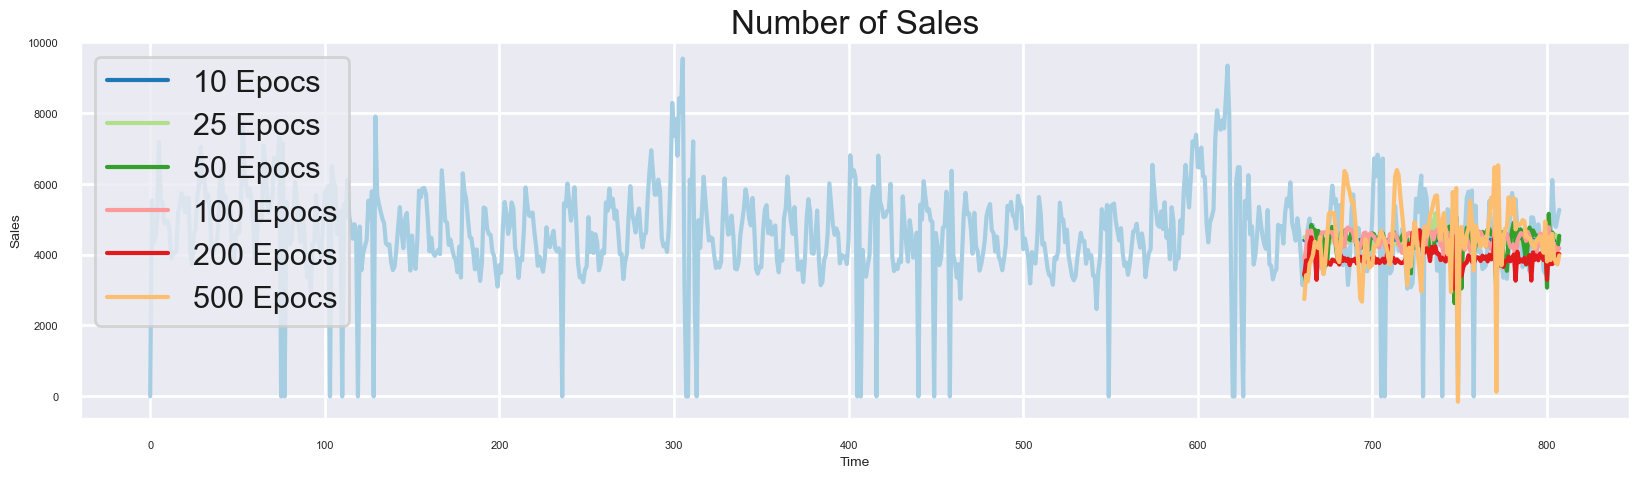

In [35]:

plt.figure(figsize = [20,5])
plt.plot(data.Sales)
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred10, label="10 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred25, label="25 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred50, label="50 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred100, label="100 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred200, label="200 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred500, label="500 Epocs")
plt.title("Number of Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

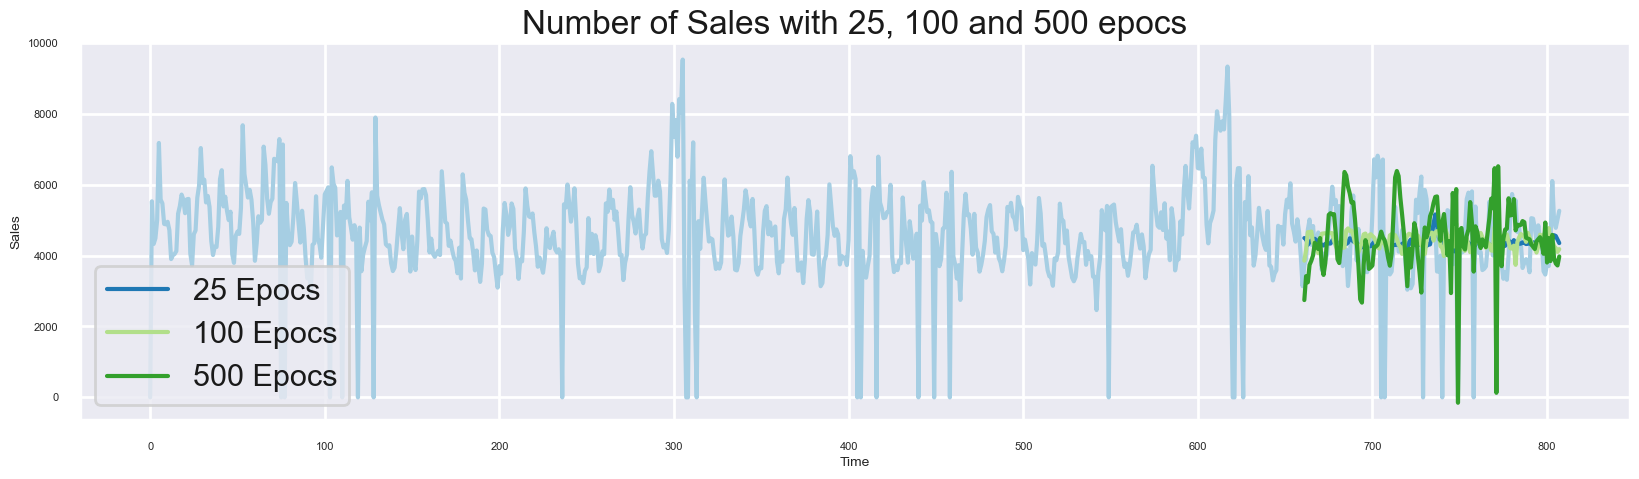

In [36]:
plt.figure(figsize = [20,5])
plt.plot(data.Sales)
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred25, label="25 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred100, label="100 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred500, label="500 Epocs")
plt.title("Number of Sales with 25, 100 and 500 epocs")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

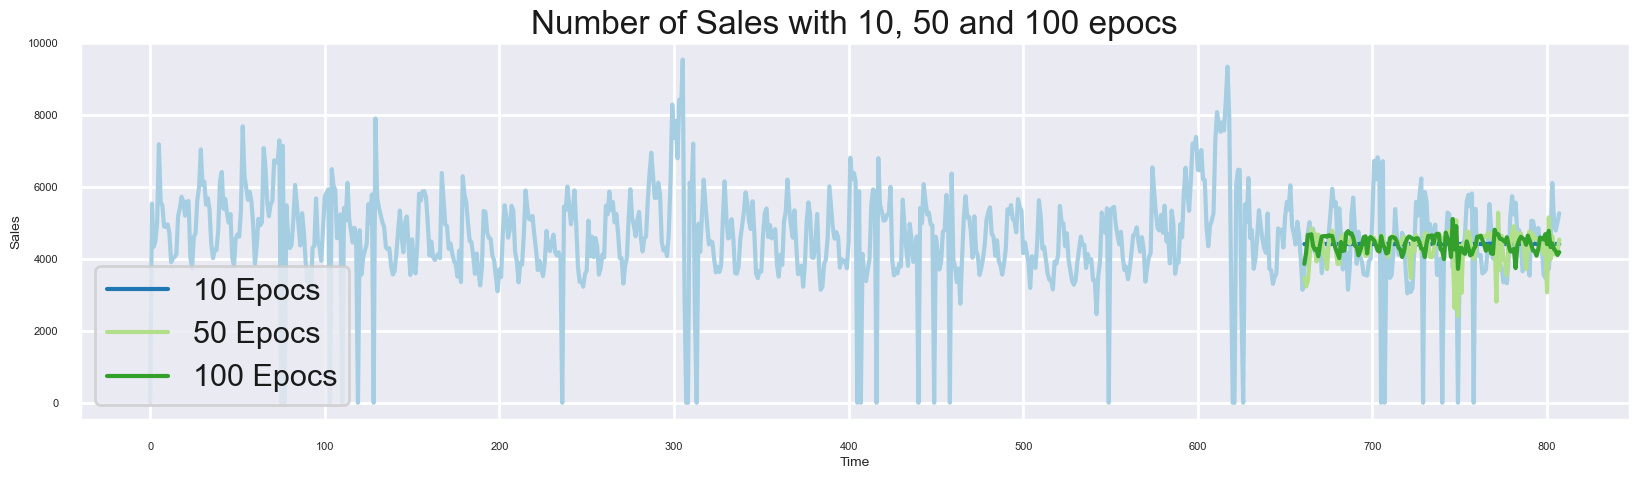

In [37]:
plt.figure(figsize = [20,5])
plt.plot(data.Sales)
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred10, label="10 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred50, label="50 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred100, label="100 Epocs")
plt.title("Number of Sales with 10, 50 and 100 epocs")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

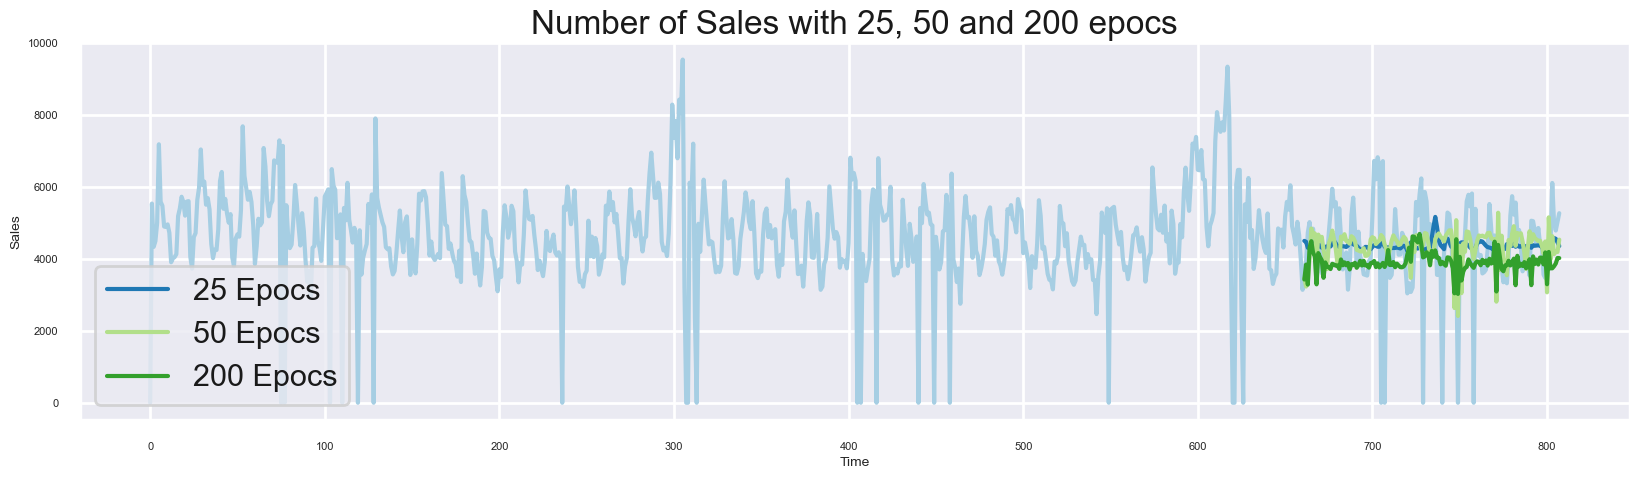

In [38]:
plt.figure(figsize = [20,5])
plt.plot(data.Sales)
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred25, label="25 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred50, label="50 Epocs")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred200, label="200 Epocs")
plt.title("Number of Sales with 25, 50 and 200 epocs")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

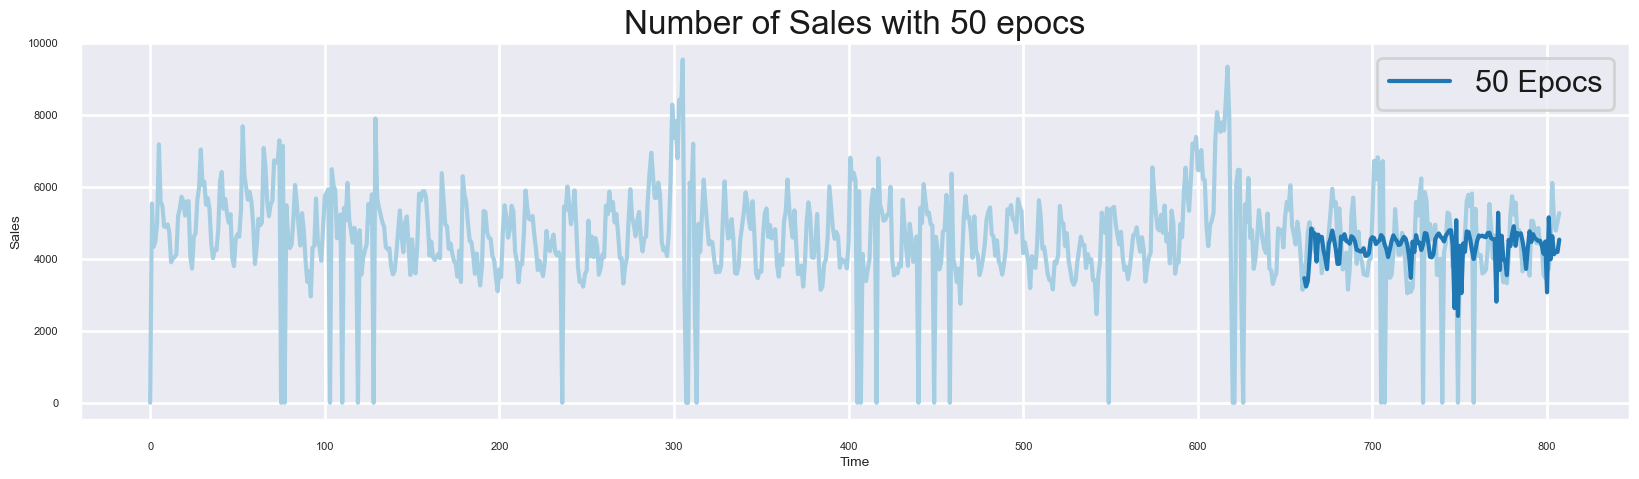

In [39]:
plt.figure(figsize = [20,5])
plt.plot(data.Sales)
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred50, label="50 Epocs")
plt.title("Number of Sales with 50 epocs")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

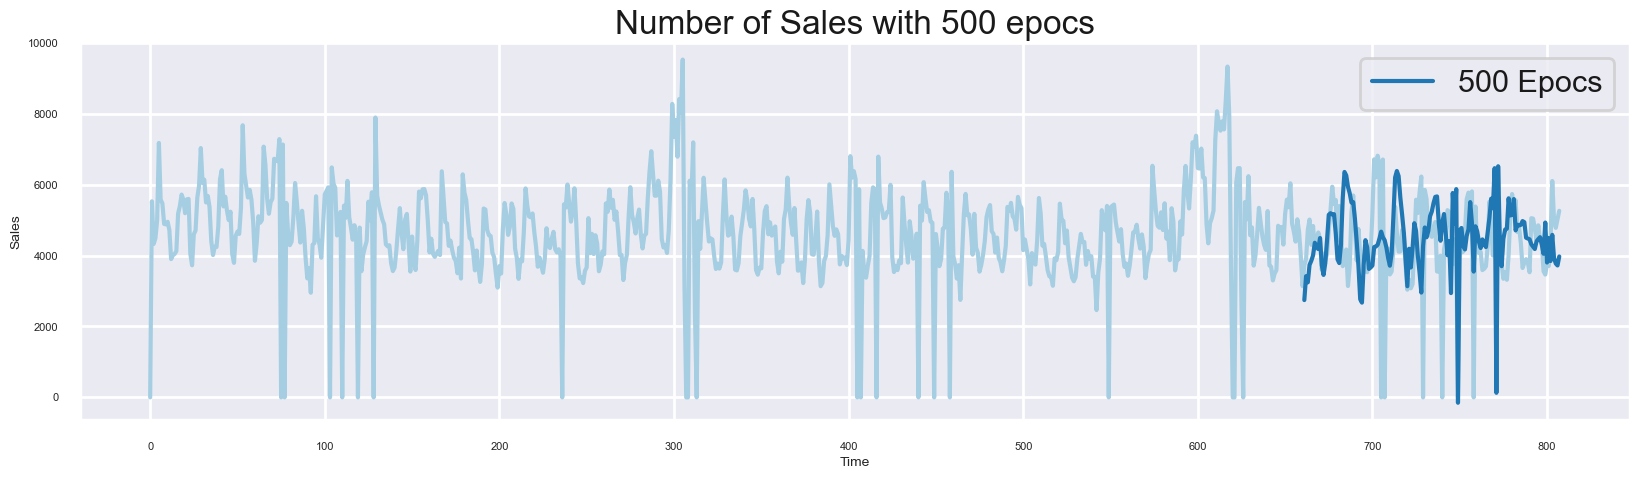

In [40]:
plt.figure(figsize = [20,5])
plt.plot(data.Sales)
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred500, label="500 Epocs")
plt.title("Number of Sales with 500 epocs")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()